In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print(tf.__version__)

2.2.0


In [28]:
df=pd.read_csv("data.csv")
df

,date,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-ATRCT (SEG),BCHAIN-NTRBL,BCHAIN-NADDU,eur_usd,cny_usd,gbp_usd,BCHAIN-MKPRU (USD)
0,2015-01-04,47.900,3009.280,65.940,16819.24,1134.55,52.230,2.950,2136.73,1.685730e+07,1.034792,1.515466e+07,2.043482e+07,8.850000,1271.209790,462086.0,1.07190,0.1453,1.26770,8343.455000
1,2015-01-05,51.690,3100.760,66.930,17177.21,1298.90,52.480,2.860,2163.26,1.689856e+07,0.976834,2.548563e+07,2.690962e+07,8.033333,983.466667,524246.0,1.04880,0.1442,1.23220,11430.181667
2,2015-01-06,52.260,3317.520,67.770,18360.54,1237.30,53.200,2.960,2246.19,1.693586e+07,0.830548,1.445054e+07,2.289248e+07,7.700000,1352.015038,418187.0,1.07690,0.1453,1.26580,8662.378333
3,2015-01-07,51.390,3273.110,67.720,19364.67,1329.00,48.860,3.080,2275.32,1.697788e+07,0.798910,1.376253e+07,2.614693e+07,9.166667,1181.335766,503405.0,1.06230,0.1449,1.22950,8340.748333
4,2015-01-08,46.525,3372.845,69.270,19499.21,1329.45,48.760,3.055,2330.29,1.701848e+07,0.623819,1.442714e+07,3.062963e+07,8.516667,1030.619103,430060.0,1.07540,0.1449,1.25810,7735.645000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2184,2020-12-27,54.540,3559.345,128.735,26662.48,1881.65,47.925,4.135,3719.21,1.859123e+07,1.305760,3.753379e+07,1.525575e+08,10.408333,2207.834413,848505.0,1.22305,0.1530,1.34745,33040.850000
2185,2020-12-28,54.290,3575.410,128.850,26656.61,1882.90,47.620,4.140,3735.36,1.859178e+07,1.292713,3.531478e+07,1.451608e+08,7.866667,2255.356688,845343.0,1.22470,0.1531,1.35000,34046.670000
2186,2020-12-29,54.330,3581.370,129.140,26854.03,1893.40,48.000,4.130,3727.04,1.859288e+07,1.293668,4.300457e+07,1.636526e+08,6.050000,2245.107345,924851.0,1.22950,0.1532,1.36220,36860.410000
2187,2020-12-30,55.470,3571.590,130.140,27568.15,1895.10,48.400,4.180,3732.04,1.859398e+07,1.269546,4.522629e+07,1.553313e+08,9.825000,2391.333333,940647.0,1.22140,0.1532,1.36730,39486.040000


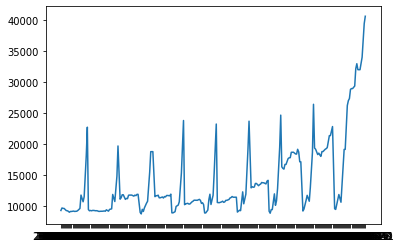

In [3]:
plt.plot(df.iloc[1900:,0], df.iloc[1900:,-1])

In [4]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg





In [65]:
ventana=10
n_cols=19
values = df.iloc[:,1:].values

scaler = MinMaxScaler(feature_range=(0, 100))
#values = scaler.fit_transform(values)

data = series_to_supervised(values, ventana,1 )

In [66]:
data

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var9(t-10),var10(t-10),...,var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t)
10,47.900,3009.280,65.940,16819.240,1134.55,52.23,2.950,2136.730,16857300.00,1.034792,...,1.060159,4.162900e+07,1.303576e+07,7.766667,2704.442857,922523.0,1.12080,0.1500,1.30780,16026.271667
11,51.690,3100.760,66.930,17177.210,1298.90,52.48,2.860,2163.260,16898562.50,0.976834,...,1.072800,4.078686e+07,1.266331e+07,8.016667,2722.625000,887697.0,1.12260,0.1499,1.29740,16047.510000
12,52.260,3317.520,67.770,18360.540,1237.30,53.20,2.960,2246.190,16935862.50,0.830548,...,1.038692,4.355294e+07,1.229086e+07,7.333333,2541.530303,853863.0,1.12540,0.1499,1.29750,15190.945000
13,51.390,3273.110,67.720,19364.670,1329.00,48.86,3.080,2275.320,16977875.00,0.798910,...,1.038692,4.355294e+07,1.229086e+07,7.333333,2541.530303,853863.0,1.12540,0.1499,1.29750,15190.945000
14,46.525,3372.845,69.270,19499.210,1329.45,48.76,3.055,2330.290,17018481.25,0.623819,...,1.038692,4.355294e+07,1.229086e+07,7.333333,2541.530303,853863.0,1.12540,0.1499,1.29750,15190.945000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2184,53.830,3560.870,128.500,26806.670,1888.90,48.36,4.130,3722.480,18585843.75,1.256575,...,1.305760,3.753379e+07,1.525575e+08,10.408333,2207.834413,848505.0,1.22305,0.1530,1.34745,33040.850000
2185,55.660,3545.740,128.600,26763.390,1882.80,49.10,4.150,3709.410,18586937.50,1.277365,...,1.292713,3.531478e+07,1.451608e+08,7.866667,2255.356688,845343.0,1.22470,0.1531,1.35000,34046.670000
2186,55.660,3545.740,128.600,26763.390,1882.80,49.10,4.150,3709.410,18586937.50,1.277365,...,1.293668,4.300457e+07,1.636526e+08,6.050000,2245.107345,924851.0,1.22950,0.1532,1.36220,36860.410000
2187,55.370,3497.210,128.325,26738.905,1876.55,48.42,4.110,3702.165,18587375.00,1.314799,...,1.269546,4.522629e+07,1.553313e+08,9.825000,2391.333333,940647.0,1.22140,0.1532,1.36730,39486.040000


In [73]:
entrenamiento=1500
n_obs=ventana*n_cols

train=data.iloc[:entrenamiento,:]
test =data.iloc[entrenamiento:,:]

train_X, train_y = train.iloc[:, :n_obs].values, train.iloc[:, -1].values
test_X, test_y = test.iloc[:, :n_obs].values, test.iloc[:, -1].values

print(print(train_X.shape, len(train_X), train_y.shape))
test_y

(1500, 190) 1500 (1500,)
None


array([ 7293.69 ,  7293.69 ,  7293.69 ,  7293.69 ,  7293.69 ,  7293.69 ,
        7293.69 ,  7293.69 ,  7293.69 ,  7362.785,  7431.88 ,  8632.32 ,
        7192.85 ,  7194.4  ,  8475.03 ,  9755.66 ,  8712.35 ,  7792.795,
        6873.24 ,  6873.24 ,  6873.24 ,  6873.24 ,  6873.24 ,  6873.24 ,
        6873.24 ,  7613.39 ,  8353.54 ,  8162.16 ,  8002.51 ,  8002.51 ,
        8039.645,  8076.78 ,  7954.15 ,  7960.04 ,  8231.06 ,  8222.52 ,
        8222.52 ,  8222.52 ,  8222.52 ,  8222.52 ,  8444.655,  8666.79 ,
        8031.38 ,  7395.97 ,  7395.97 ,  8601.755,  9807.54 ,  8531.42 ,
        6189.85 ,  6891.6  ,  6891.6  ,  8072.295,  9252.99 ,  9301.18 ,
        9206.16 ,  9418.05 ,  9418.05 ,  9418.05 ,  9364.12 ,  9310.19 ,
        9343.34 ,  9204.24 ,  8766.04 ,  8809.41 ,  8809.41 ,  8923.265,
        9037.12 ,  8717.81 ,  8717.81 ,  8717.81 ,  8988.805,  9259.8  ,
        8403.495,  7547.19 ,  7243.93 ,  8900.34 ,  9907.12 ,  7864.87 ,
        5822.62 ,  6915.37 ,  8081.81 ,  7617.07 , 

In [74]:
train_X = train_X.reshape((train_X.shape[0], ventana, n_cols))
test_X = test_X.reshape((test_X.shape[0], ventana, n_cols))

In [75]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True,input_shape=[train_X.shape[1],train_X.shape[2]])),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(40,activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 500.0)
])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),metrics=["mae"])
history = model.fit(train_X,train_y,shuffle=False,validation_data=(test_X,test_y),epochs=1000)

ch 864/1000
47/47 [==============================] - 0s 7ms/step - loss: 2366.0532 - mae: 2366.5532 - val_loss: 3653.9644 - val_mae: 3654.4644
Epoch 865/1000
47/47 [==============================] - 0s 7ms/step - loss: 2380.1477 - mae: 2380.6477 - val_loss: 3654.7876 - val_mae: 3655.2876
Epoch 866/1000
47/47 [==============================] - 0s 7ms/step - loss: 2332.1030 - mae: 2332.6030 - val_loss: 3655.0632 - val_mae: 3655.5632
Epoch 867/1000
47/47 [==============================] - 0s 7ms/step - loss: 2320.2217 - mae: 2320.7217 - val_loss: 3655.2983 - val_mae: 3655.7979
Epoch 868/1000
47/47 [==============================] - 0s 7ms/step - loss: 2362.5295 - mae: 2363.0295 - val_loss: 3655.4636 - val_mae: 3655.9636
Epoch 869/1000
47/47 [==============================] - 0s 7ms/step - loss: 2314.2969 - mae: 2314.7969 - val_loss: 3655.8398 - val_mae: 3656.3398
Epoch 870/1000
47/47 [==============================] - 0s 7ms/step - loss: 2310.9456 - mae: 2311.4456 - val_loss: 3656.5752 - 

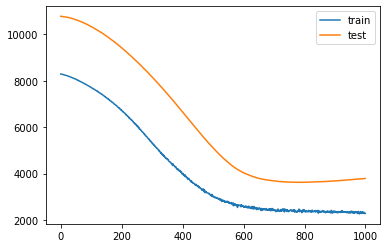

In [76]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [77]:
y_pred=model.predict(test_X)

(400.0, 700.0, 0.0, 35000.0)

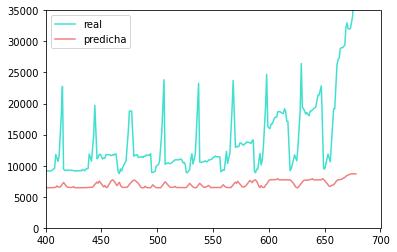

In [82]:
plt.plot(test_y, color="turquoise",label="real")
plt.plot(y_pred, color="lightcoral",label="predicha")
plt.legend()
plt.axis([400,700,0,35000])

In [87]:
y_pred=model.predict(train_X)

(700.0, 900.0, 0.0, 35000.0)

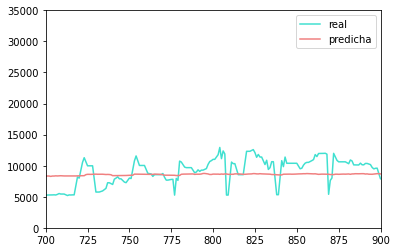

In [90]:
plt.plot(train_y, color="turquoise",label="real")
plt.plot(y_pred, color="lightcoral",label="predicha")
plt.legend()
plt.axis([700,900,0,35000])

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], ventana*n_cols))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -19:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -18:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


ValueError: operands could not be broadcast together with shapes (682,20) (19,) (682,20) 